In [36]:
import json
import os
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import seaborn as sns

from collections import namedtuple
from gensim.models import KeyedVectors
from tqdm import tqdm, trange

sns.set()

In [29]:
data_prefix = "../datasets"

controversial_comments_path = os.path.join(data_prefix, "RC_2018-03.filtered.c")
noncontroversial_comments_path = os.path.join(data_prefix, "RC_2018-03.filtered.nc")
comment_dataset = os.path.join(data_prefix, "RC_2018-03.filtered")

glove_path = os.path.join(data_prefix, "glove.840B.300d.txt")
glove_dim = 300
glove_vocab_size = 2196017

batch_size = 100
max_comment_len = 200

In [30]:
controversial_comments_df = pd.read_json(controversial_comments_path, lines=True, chunksize=1e4).read()
controversial_comments_df = controversial_comments_df[
    (controversial_comments_df.controversiality != 0) &
    (controversial_comments_df.body != '[deleted]') &
    (controversial_comments_df.body != '[removed]')
]

/Users/kvchen/code/cs224u-final-project/notebooks/.env/lib/python3.6/site-packages/pandas/io/json/json.py:521: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  obj = concat(self)



 42%|████▏     | 919764/2196017 [01:42<02:21, 9002.94it/s] 

Text(0.5,1,'Controversial comment lengths')

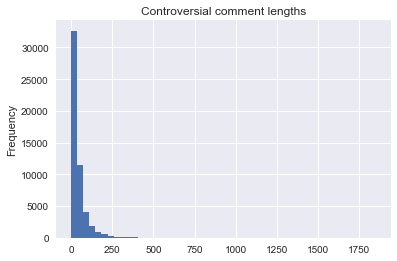

In [31]:
controversial_comments_lens = controversial_comments_df['body'].apply(nltk.tokenize.word_tokenize).str.len()

plt.figure()
# comment_lens.plot.hist(bins=50)
controversial_comments_lens.plot.hist(bins=50)
plt.title('Controversial comment lengths')

In [34]:
# Parse GloVe vectors

PAD_TOKEN = b"<PAD>"
PAD_ID = 0

UNK_TOKEN = b"<UNK>"
UNK_ID = 1

def get_glove(glove_path, glove_dim, vocab_size):
    initial_vocab = [PAD_TOKEN, UNK_TOKEN]
    embed_matrix = np.zeros((int(vocab_size + len(initial_vocab)), glove_dim))
    word2id = {word: idx for idx, word in enumerate(initial_vocab)}
    
    with open(glove_path, 'r') as infile:        
        for idx, line in enumerate(infile):
            try:
                idx_offset = idx + len(initial_vocab)

                word, *word_vec_raw = line.rsplit(maxsplit=glove_dim)
                word_vec = np.array([float(v) for v in word_vec_raw])

                embed_matrix[idx_offset, :] = word_vec
                word2id[word] = idx_offset
            except:
                print(line)
                print(word)
                print(word_vec)
                

    id2word = {v: k for k, v in word2id.items()}
    return embed_matrix, word2id, id2word

In [35]:
model = KeyedVectors.load_word2vec_format(tmp_file)
# embed_matrix, word2id, id2word = get_glove(glove_path, glove_dim, glove_vocab_size)

  0.20785 0.2703 0.93632 -0.50861 -0.36674 -0.042177 -0.37699 0.051295 0.61275 -0.42422 -0.034888 -0.19135 0.64608 0.5798 -0.076789 0.26753 -0.075789 -0.35367 0.19077 0.14558 0.0814 0.24152 0.046535 0.32054 -0.95148 -0.45128 -0.34587 0.20727 0.089065 0.062543 0.20752 -0.29543 0.79427 0.49611 -0.0011539 0.15531 0.21641 0.14618 0.29269 0.054468 0.51529 -0.17125 0.11044 -0.14752 -0.69757 -0.026229 -0.12325 -0.12212 0.11973 0.19259 0.40017 -0.43404 0.13098 -0.061418 -0.17673 -0.81071 -0.26014 -0.47192 0.61194 -0.11891 -0.35838 -0.33293 0.84064 -0.22047 -0.66912 0.21979 0.41868 0.61312 0.23073 0.3371 -0.12788 -0.48915 0.3037 0.017401 0.33886 -0.35593 -0.57258 0.46135 -0.057631 -0.36917 -0.53401 -0.045035 -0.22714 0.13939 -0.025597 -0.12937 0.70547 -0.74619 0.48864 -0.13882 -0.14221 -0.15263 -0.45785 -0.33056 0.45977 0.58663 0.35718 0.12967 0.23003 0.63797 0.2097 0.44999 0.70432 0.66536 0.073387 -0.27004 0.66423 -0.95498 -0.6618 -0.26601 -0.10039 -0.20239 0.11026 -0.17554 0.27676 0.35229 -0.

In [8]:
Batch = namedtuple(
    'Batch',
    ['comment_tokens', 'comment_ids', 'comment_masks', 'controversialities'],
)

def parse_comment(comment, word2id, max_comment_len):
    comment_tokens = nltk.tokenize.word_tokenize(comment['body'])[:max_comment_len]
    if len(comment_tokens) < max_comment_len:
        comment_tokens += [PAD_TOKEN] * (max_comment_len - len(comment_tokens))
    
    comment_ids = np.array([word2id.get(token, UNK_ID) for token in comment_tokens])
    comment_mask = (comment_ids != PAD_ID).astype(np.int32)
    
    controversiality = comment['controversiality']
    return (comment_tokens, comment_ids, comment_mask, controversiality)
    
    
def create_batch(parsed_comments):
    grouped = list(zip(*parsed_comments))
    return Batch(
        comment_tokens=grouped[0],
        comment_ids=np.array(grouped[1]),
        comment_masks=np.array(grouped[2]),
        controversialities=np.array(grouped[3]).reshape(-1, 1),
    )
    

def generate_batches(dataset_path, word2id, batch_size=100, max_comment_len=200):
    """An infinite generator of batches. Just keeps looping through
    the training dataset forever, generating batches.
    """
    parsed_comments = []
    
    while True:
        with open(dataset_path, 'r') as infile:
            parsed_comments = []
            for idx, line in enumerate(infile):
                comment = json.loads(line)
                parsed_comments.append(parse_comment(comment, word2id, max_comment_len))
                
                if len(parsed_comments) == batch_size:
                    batch = create_batch(parsed_comments)
                    parsed_comments = []
                    yield batch

In [9]:
batch_generator = generate_batches(
    comment_dataset_path,
    word2id,
    batch_size,
    max_comment_len,
)

Model training time!

In [10]:
def masked_softmax(logits, mask, dim):
    exp_mask = (1 - tf.cast(mask, 'float')) * -1e30
    masked_logits = tf.add(logits, exp_mask)
    prob_dist = tf.nn.softmax(masked_logits, dim)
    return masked_logits, prob_dist

In [11]:
tf.reset_default_graph()

# Placeholders

comments = tf.placeholder(tf.int32, (None, max_comment_len), name="comments")
comment_masks = tf.placeholder(tf.int32, (None, max_comment_len), name="comment_masks")
labels = tf.placeholder(tf.int32, (None, 1), name="labels")

# Embedding lookup

with tf.variable_scope('embed'):
    tf_embed_matrix = tf.constant(
        embed_matrix,
        dtype=tf.float32,
        name="embed_matrix"
    )
    comment_vecs = tf.nn.embedding_lookup(tf_embed_matrix, comments)

# RNN

lstm_cell_size = 64
keep_prob = 0.75

with tf.variable_scope('lstm'):
    lstm_forward = tf.contrib.rnn.BasicLSTMCell(lstm_cell_size)
    lstm_backward = tf.contrib.rnn.BasicLSTMCell(lstm_cell_size)

    # out = tf.nn.dynamic_rnn(lstm_forward, comment_vecs, dtype=tf.float64)
    (fw_out, bw_out), _ = tf.nn.bidirectional_dynamic_rnn(
        lstm_forward,
        lstm_backward,
        comment_vecs,
        sequence_length=tf.reduce_sum(comment_masks, axis=1),
        dtype=tf.float32,
    )
    
    rnn_out = tf.concat([fw_out, bw_out], axis=2)[:, -1, :]
    rnn_out = tf.nn.dropout(rnn_out, keep_prob)
    
with tf.variable_scope('output'):
    logits = tf.contrib.layers.fully_connected(
        rnn_out,
        num_outputs=2,
        activation_fn=None,
    )

# Loss optimization

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
loss = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)  # what the fuck?

# Check accuracy

correct = tf.equal(tf.argmax(logits, 1, output_type=tf.int32), labels)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
summary_op = tf.summary.merge_all()

In [12]:
with tf.Session() as sess:
    logdir = os.path.join('summary', str(int(time.time())))
    writer = tf.summary.FileWriter(logdir, sess.graph)
    saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())

    for i in trange(int(1e4)):
        batch = next(batch_generator)
        _, summary = sess.run(
            [train_op, summary_op],
            {
                "comments:0": batch.comment_ids,
                "comment_masks:0": batch.comment_masks,
                "labels:0": batch.controversialities,
            }
        )        
        writer.add_summary(summary, i)

 19%|█▊        | 1870/10000 [07:50<34:05,  3.97it/s]

KeyboardInterrupt: 